In [1]:
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random

In [2]:
# Loadingw NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:

labelling_keys = {
    'Bug': ['bug', 'error', 'issue', 'glitch', 'malfunction', 'fault', 'defect', 'failure',
            'anomaly', 'problem', 'flaw', 'error message', 'crash', 'hang', 'freeze', 'unexpected behavior',
            'non-responsive', 'runtime error', 'not working', 'broken', 'wrong', 'unresponsive', 'slow', 'stuck',
            'hangs', 'crashing', 'error code', 'freezing', 'lag', 'blank screen', 'disconnects', 'fails', 'corruption',
            'data loss', 'inconsistency', 'interruption', 'misbehavior', 'performance issue', 'sync problem', 'bug report',
            'code fix', 'debugging', 'program error', 'system crash', 'application error', 'software issue', 'coding mistake',
            'logic error', 'exception', 'instability', 'incorrect output', 'infinite loop', 'memory leak', 'stack trace',
            'segmentation fault', 'compiler error', 'fatal error', 'kernel panic', 'core dumped', 'pytest failed', 'build failed' ],
    'Feature request': ['feature request', 'enhancement', 'improvement', 'addition', 'upgrade', 'new functionality',
                        'enhanced capability', 'extension', 'modification', 'update request', 'new feature',
                        'improvement suggestion', 'expansion', 'development request', 'optimization', 'refinement',
                        'customization', 'user experience improvement', 'want', 'need', 'add', 'wish', 'suggest',
                        'hope for', 'could use', 'should have', 'requesting', 'looking for', 'asking for', 'desire',
                        'would like', 'prefer', 'would be nice', 'integration', 'usability', 'accessibility', 'compatibility',
                        'automation', 'scalability', 'user story', 'roadmap item', 'new capability', 'additional functionality',
                        'enhanced performance', 'simplification', 'modernization', 'better interface', 'personalization',
                        'configurability', 'extensibility', 'improved workflow', 'developer experience', 'lower cost',
                        'increased adoption', 'competitive advantage', 'business value', 'delight users', 'reduce churn',
                        'boost retention', 'higher engagement', 'organic growth', 'improved outcomes', 'strategic priority'],
    'Theoretical Question': ['theoretical question', 'conceptual query', 'conceptual discussion', 'theoretical exploration',
                             'abstract inquiry', 'philosophical question', 'fundamental query', 'conceptual clarification',
                             'principles question', 'theoretical framework', 'concept examination', 'foundational query',
                             'academic question', 'speculative inquiry', 'concept analysis', 'theoretical examination',
                             'modeling question', 'why', 'how does', 'what is', 'explain', 'meaning of', 'purpose of',
                             'reason for', 'basics of', 'understand', 'clarify', 'difference between', 'simple explanation',
                             'overview of', 'in simple terms', 'basic concept', 'logical inquiry', 'strategic question',
                             'analytical query', 'methodological question', 'philosophical query', 'intellectual challenge',
                             'theoretical challenge', 'ontological discussion', 'epistemic question', 'metaphysical analysis',
                             'theoretical discourse', 'hypothetical reasoning', 'thought experiment', 'conceptual analysis',
                             'theoretical construct', 'rationalist perspective', 'empiricist critique', 'exploratory dialogue',
                             'assumption examination', 'logical positivism', 'critical rationalism', 'paradigm analysis',
                             'anthropic principle', 'rationalism vs empiricism' ],
    'Security': ['security', 'vulnerability', 'threat', 'exploit', 'risk', 'penetration', 'data breach', 'compromise',
                 'hacking', 'data protection', 'cybersecurity', 'information security', 'privacy concern', 'security breach',
                 'intrusion', 'phishing', 'authentication issue', 'encryption concern', 'safe', 'protect', 'secure', 'risk',
                 'hack', 'privacy', 'leak', 'safe to use', 'data safety', 'secure enough', 'password', 'firewall',
                 'safety concern', 'confidential', 'access control', 'compliance', 'cyber attack', 'identity theft',
                 'security policy', 'malware', 'spyware', 'security audit', 'virus', 'trojan', 'worm', 'ransomware',
                 'keylogger', 'botnet', 'rootkit', 'cryptojacking', 'brute force', 'sql injection', 'ddos attack',
                 'data encryption', 'firewall', 'vpn', 'ssh keys', 'https', 'tls', 'saml', 'rbac'],
}

In [4]:
# Preprocessing and cleaning the text
def text_cleaning(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization
    return ' '.join(words)

# Function to categorize prompts by keywords
def prompt_categorization_by_labelling_keys(cleaned_prompt, labelling_keys):
    for label, keywords in labelling_keys.items():
        for keyword in keywords:
            if keyword in cleaned_prompt.lower():
                return label
    return 'null'  # Default label if no keywords match


In [5]:
def preprocessing_and_loading_data(file_names):
    all_texts = []
    all_labels = []
    prompts_by_category = {label: [] for label in labelling_keys if label != 'null'} 

    for file_name in file_names:
        with open(file_name, 'r') as file:
            data = json.load(file)
            for data1 in data['Sources']:
                for record in data1.get('ChatgptSharing', []):
                    for conversation in record.get('Conversations', []):
                        prompt = conversation.get('Prompt', '')
                        cleaned_prompt = text_cleaning(prompt)
                        label = prompt_categorization_by_labelling_keys(cleaned_prompt, labelling_keys)
                        # Exclude 'other' category labels
                        if label in prompts_by_category:
                            all_texts.append(cleaned_prompt)
                            all_labels.append(label)
                            prompts_by_category[label].append(prompt)  # Store prompts by category

    for label, prompts in prompts_by_category.items():
        print(f"Category: {label}")
        print(f"Total Prompts: {len(prompts)}")
        print("-------------------------------")
        random.shuffle(prompts)
        sample_count = 1
        for prompt in prompts:
            print(f"{sample_count}. {prompt}")
            print("-------------------------------")
            sample_count += 1
            if sample_count > 5:
                break

        print("\n\n")

    return all_texts, all_labels, prompts_by_category

In [8]:
data_files = ['discuss.json', 'issues.json', 'commit.json','pr_sharings.json','hn_sharings.json','file_sharing.json']

texts, labels, prompts_by_category = preprocessing_and_loading_data(data_files)

Category: Bug
Total Prompts: 5195
-------------------------------
1. forsæt det her

okay hvordan starter jeg så vores engine op
ChatGPT

For at starte motoren op, skal du oprette en "main" fil, hvor du initialiserer og kører hovedspilsløjfen. Her er et eksempel på, hvordan du kan gøre det:
main.cpp (gem i spillemappe/src/)

cpp

#include "game_loop.h"

int main() {
    GameLoop gameLoop;
    gameLoop.run();
    return 0;
}

Dette vil starte spilmotoren og køre hovedspilsløjfen, som vi har defineret tidligere.
Kompilering og Linking

For at kompilere og køre koden, skal du også opsætte et byggesystem, der linker de nødvendige biblioteker (som OpenGL, GLFW, OpenAL osv.). Dette kan variere afhængigt af dit udviklingsmiljø og operativsystem.

Her er et eksempel på en CMake-fil, som du kan bruge til at bygge projektet:
CMakeLists.txt (gem i spillemappe/)

cmake

cmake_minimum_required(VERSION 3.10)
project(Spillemotor)

set(CMAKE_CXX_STANDARD 17)

find_package(OpenGL REQUIRED)
find_package

In [9]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convert texts to a matrix of TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)
# Create and train the SVM model
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
# Evaluate the model
y_pred = clf.predict(X_test)

In [11]:
accuracy = clf.score(X_test, y_test) *100
print(f"Accuracy of the model: {accuracy}")

Accuracy of the model: 89.20786815523658


In [12]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
                      precision    recall  f1-score   support

                 Bug       0.90      0.94      0.92      1015
     Feature request       0.87      0.90      0.89       688
            Security       1.00      0.46      0.63        81
Theoretical Question       0.91      0.70      0.79        97

            accuracy                           0.89      1881
           macro avg       0.92      0.75      0.81      1881
        weighted avg       0.89      0.89      0.89      1881



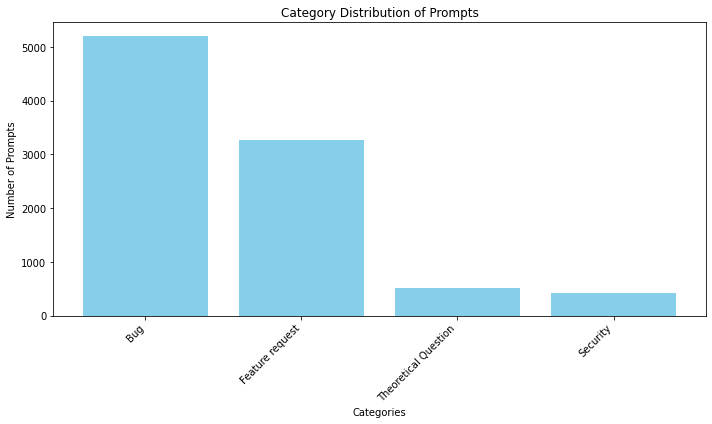

In [14]:
categories = list(prompts_by_category.keys())
counts = [len(prompts) for prompts in prompts_by_category.values()]
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Prompts')
plt.title('Category Distribution of Prompts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [15]:
def category_prediction(new_prompt, vectorizer, clf, label_encoder):
    cleaned_prompt = text_cleaning(new_prompt)
    vectorized_prompt = vectorizer.transform([cleaned_prompt])
    predicted_label = clf.predict(vectorized_prompt)
    predicted_category = label_encoder.inverse_transform(predicted_label)
    return predicted_category[0]

In [16]:
new_prompt = input("Enter a prompt to classify: ")
predicted_category = category_prediction(new_prompt, vectorizer, clf, label_encoder)
print(f"The predicted category for the prompt is: {predicted_category}")

Enter a prompt to classify: How can I protect user passwords stored in a database? What hashing algorithms should I use?
The predicted category for the prompt is: Security
